<a href="https://colab.research.google.com/github/Sadie-Zhao/-Generative-Adversarial-Inverse-Multiagent-Learning-ICLR2024/blob/main/Stochastic_Fisher_Markets_(Inverse_Game).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Fisher Market Experiments

## Neural Networks

In [ ]:
@struct.dataclass
class Policy:
    """A class that stores network and parameters, and applies the policy to a state.
    Attributes:
        network: A Haiku network.
        params: The parameters of the network.
    """

    network: hk.Transformed = struct.field(pytree_node=False)
    params: hk.Params

    def __call__(self, state, *args):
        """Applies the policy to a state.
        Args:
            state: A state of the market.
        Returns:
            The output of the network for the given state.
        """
        return self.network.apply(self.params, state, *args)

def _prices_actor_forward(state):
    # pi: s=(e, t, b) -> p where p is a price vector
    supplies = state["supplies"]
    types = state["types"]
    budgets = state["budgets"]
    num_buyers, num_goods = types.shape

    types_flat = types.flatten()
    types_latent = LinearLayer(100, jax.nn.relu)(types_flat)

    supplies_latent = LinearLayer(100, jax.nn.relu)(supplies)

    budgets_latent = LinearLayer(100, jax.nn.relu)(budgets)
    budgets_share = LinearLayer(100, jax.nn.relu)(budgets_latent)
    budgets_share = LinearLayer(1, jax.nn.sigmoid)(budgets_share)
    budgets_sum = jnp.sum(budgets, axis=-1)
    budgets_spent = budgets_sum * budgets_share

    prices_latent = jnp.concatenate((types_latent, supplies_latent, budgets_latent), axis = -1)
    prices_latent = LinearLayer(100, jax.nn.relu)(prices_latent)
    prices_latent = LinearLayer(100, jax.nn.relu)(prices_latent)
    prices_latent = LinearLayer(100, jax.nn.relu)(prices_latent)
    prices_shares = LinearLayer(num_goods, jax.nn.softmax)(prices_latent)

    prices = budgets_spent * prices_shares

    return  prices

###########################################################################################################################################################
def _buyer_actor_forward(state, prices):
    # pi: s=(b, p) -> a' where a' is the budget share matrix
    supplies = state["supplies"]
    types = state["types"]
    budgets = state["budgets"]
    num_buyers, num_goods = types.shape


    p_tiled = jnp.tile(prices, [num_buyers, 1])


    # types_latent = jnp.concatenate([types, 1/types.clip(min = 1e-5)], axis = -1)
    types_latent = types
    types_latent = LinearLayer(100, jax.nn.relu)(types_latent)

    # prices_latent = jnp.concatenate([p_tiled, 1/p_tiled.clip(min = 1e-5)], axis = -1)
    prices_latent = p_tiled
    prices_latent = LinearLayer(100, jax.nn.relu)(prices_latent)

    budgets_latent = jnp.concatenate([budgets[...,jnp.newaxis], 1/budgets[...,jnp.newaxis].clip(min = 1e-5)], axis = - 1)
    budgets_latent = LinearLayer(100, jax.nn.relu)(budgets_latent)


    buyer_latent = jnp.concatenate([types_latent, prices_latent, budgets_latent], axis = -1)

    buyer_latent = LinearLayer(100, jax.nn.relu)(buyer_latent)
    buyer_latent = LinearLayer(100, jax.nn.relu)(buyer_latent)

    buyer_latent = jnp.squeeze(LinearLayer(1)(buyer_latent))# + budgets
    saving_coef = jax.nn.sigmoid(buyer_latent)
    savings = saving_coef * budgets

    disposable_income = budgets - savings

    allocs_coefs = LinearLayer(num_goods, jax.nn.softmax)(buyer_latent)

    # Project to budget simplex
    budget_matrix = jnp.tile(disposable_income, [num_goods, 1]).T
    budget_simplices = budget_matrix / p_tiled.clip(min = 1e-8)
    allocations = allocs_coefs * budget_simplices

    return  allocations, savings



def _market_actor_forward(state):
    """
    A best-response policy network that returns best-reponse allocations, savings, and prices
    for a given state.
    NOTE: Should be replaced with a more sophisticated network for better performance with given utility functions.
    Parameters:
    -----------
    state : dict
        A dictionary containing the state of the market.

    Returns:
    --------
    A tuple containing the best-response allocations, savings, and prices.
    """

    prices = _prices_actor_forward(state)
    allocations, savings = _buyer_actor_forward(state, prices)
    return  prices, (allocations, savings)

def _br_network(state):
    """
    A best-response policy network that returns best-reponse allocations, savings, and prices
    for a given state.
    NOTE: Should be replaced with a more sophisticated network for better performance with given utility functions.
    Parameters:
    -----------
    state : dict
        A dictionary containing the state of the market.

    Returns:
    --------
    A tuple containing the best-response allocations, savings, and prices.
    """
    prices = _prices_actor_forward(state)
    allocations, savings = _buyer_actor_forward(state, prices)

    return  prices, (allocations, savings)

def _param_actor_forward(world_state):
    world_state_latent = LinearLayer(100, jax.nn.relu)(world_state)
    world_state_latent = LinearLayer(100, jax.nn.relu)(world_state)
    world_state_latent = LinearLayer(100, jax.nn.relu)(world_state)
    world_state_latent = LinearLayer(100, jax.nn.relu)(world_state)

    supplies = jax.random.uniform(next(prng_keys), shape = (num_goods,), minval = 0, maxval = 10)
    types = jax.random.uniform(next(prng_keys), shape = (num_buyers, num_goods), minval = 0, maxval = 10)
    budgets = jax.random.uniform(next(prng_keys), shape = (num_buyers,), minval = 0, maxval = 10)
    init_state = {"supplies": supplies, "types": types, "budgets": budgets}

    ir = jax.random.uniform(next(prng_keys), shape = (1,), minval = 0.5, maxval = 1.5)
    replenishment = jax.random.uniform(next(prng_keys), shape = (num_buyers, ), minval = 0, maxval = 10)
    discount = jax.random.uniform(next(prng_keys), shape = (1,), minval = 0, maxval = 1)

    init_market_params = {"init_state": init_state,
                          "ir": ir,
                          "replenishment": replenishment,
                          "discount": discount}

### Evaluation

## Estimate Market

### Estimation Function

In [ ]:
def plot_price_prediction(l_action, f_action):
    market_actor_network = hk.without_apply_rng(hk.transform(_market_actor_forward))

    price_policy = lambda state: market_actor_network.apply(f_action, state)[0]
    buyer_policy = lambda state: market_actor_network.apply(f_action, state)[1]

    # price_history = df_final_norm[['price actual']].values[1:]

    traj = market.trajectory(l_action, price_policy, buyer_policy, num_episodes)

    f_prices_hist = traj.a
    f_alloc_hist = traj.b[0]
    f_saving_hist = traj.b[1]

    val_start = prices_train.shape[0]
    test_start = prices_train.shape[0] + prices_val.shape[0]

    # plt.plot(price_history)
    plt.plot(f_prices_hist)
    # plt.axvline(x=val_start, color='r', linestyle='--')
    # plt.axvline(x=test_start, color='g', linestyle='--')
    plt.show()

def estimate_market_params(eqm_play_hist, learn_rates, num_iters, beta_mult, beta, num_buyers, num_goods, num_episodes, num_br_epochs, util_type = "linear", opt_name = "adam"):
    #Initialize PRNG keys
    prng_keys = hk.PRNGSequence(seed)

    # Initialize market type
    if util_type == "linear":
        utils = lambda X, T: jnp.sum(T * X, axis = 1).clip(1e-5)
    elif util_type == "cd":
        utils = lambda X, T: jnp.prod(jnp.power(X, T), axis = 1).clip(1e-5)
    elif util_type == "leontief":
        utils = lambda X, T: jnp.min(X / T, axis = 1).clip(1e-5)
    else:
        raise ValueError("Invalid utility function!")

    utils = jax.jit(utils)

    br_network = hk.without_apply_rng(hk.transform(_br_network))
    market_actor_network = hk.without_apply_rng(hk.transform(_market_actor_forward))

    market = sf.StochasticFisher(utils, market_actor_network, br_network, seed)


    # Initialize equilbirium trajectory
    price_hist, alloc_hist, saving_hist = eqm_play_hist

    # Initialize learning rates
    learn_rate_players, learn_rate_langmult, learn_rate_br = learn_rates



    ####### Initalize market parameters #######
    supplies = jax.random.uniform(next(prng_keys), shape = (num_goods,), minval = 0, maxval = 10)
    types = jax.random.uniform(next(prng_keys), shape = (num_buyers, num_goods), minval = 0, maxval = 10)
    budgets = jax.random.uniform(next(prng_keys), shape = (num_buyers,), minval = 0, maxval = 10)
    init_state = {"supplies": supplies, "types": types, "budgets": budgets}

    ir = jax.random.uniform(next(prng_keys), shape = (1,), minval = 0.5, maxval = 1.5)
    replenishment = jax.random.uniform(next(prng_keys), shape = (num_buyers, ), minval = 0, maxval = 10)
    discount = jax.random.uniform(next(prng_keys), shape = (1,), minval = 0, maxval = 1)

    init_market_params = {"init_state": init_state,
                          "ir": ir,
                          "replenishment": replenishment,
                          "discount": discount}


    ####### Initalize equilibrium parameters #######
    market_actor_params = market_actor_network.init(next(prng_keys), init_state)

    ####### Initalize Lagrange multipliers #######
    init_langmult = jax.random.uniform(next(prng_keys), shape = (1,), minval = 0.0, maxval = 0.1)

    # Initialize exploitability parameters
    init_exploit_params = {"init_br_params": market.br_network.init(next(prng_keys), init_state)}

    # Collect all initial parameters
    init_params = (init_market_params, market_actor_params, init_langmult)

    def obj(l_action, f_action):
        traj_len = len(price_hist)

        price_policy = lambda state: market_actor_network.apply(f_action, state)[0]
        buyer_policy = lambda state: market_actor_network.apply(f_action, state)[1]

        traj = market.trajectory(l_action, price_policy, buyer_policy, traj_len)
        f_price_hist = traj.a
        f_alloc_hist = traj.b[0]
        f_saving_hist = traj.b[1]

        return jnp.linalg.norm(alloc_hist - f_alloc_hist) \
               + jnp.linalg.norm(price_hist - f_price_hist) \
               + jnp.linalg.norm(saving_hist - f_saving_hist)

    def exploit(l_action, f_action, init_br_params):
        exploit, init_br_params = market.exploit(l_action, f_action, learn_rate_br, num_episodes, num_br_epochs, init_br_params)
        return exploit, {"init_br_params": init_br_params}


    def project_market(l_action):
        # jax.debug.print("initial state before projection {l_proj}", l_proj = l_action["init_state"])
        init_state_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1e-8), l_action["init_state"])
        init_state_proj["budgets"] = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max = 10.0), init_state_proj["budgets"])
        init_state_proj["types"] = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=15.0, a_max= 35.0), init_state_proj["types"])
        init_state_proj["supplies"] = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max= 1.0), init_state_proj["supplies"])
        # 30.0*jaxopt.projection.projection_simplex(init_state_proj["budgets"]) # Here 10.0 is a scaling factor to the budgets for numerical stability.
        # jax.debug.print("initial state after projection {l_proj}",  l_proj = init_state_proj)
        ir_proj = jnp.clip(ir, a_min=1.0, a_max=1.0)
        replenishment_proj = jnp.clip(replenishment, a_min=1.0, a_max=1.0)
        discount_proj = jnp.clip(discount, a_min=0.9, a_max=0.9)

        l_action_proj = {"init_state": init_state_proj,
                          "ir": ir_proj,
                          "replenishment": replenishment_proj,
                          "discount": discount_proj}
        return l_action_proj

    l_project = project_market
    f_project = lambda x: x

    def plot_price_prediction(l_action, f_action):
        price_policy = lambda state: market_actor_network.apply(f_action, state)[0]
        buyer_policy = lambda state: market_actor_network.apply(f_action, state)[1]

        # price_history = df_final_norm[['price actual']].values[1:]

        traj = market.trajectory(l_action, price_policy, buyer_policy, num_episodes)


        f_prices_hist = traj.a
        f_alloc_hist = traj.b[0]
        f_saving_hist = traj.b[1]

        sns.set_style("darkgrid")
        fig, ax = plt.subplots()
        ax.plot(price_hist, label='Real prices')
        ax.plot(f_prices_hist, label='Predicted prices')
        ax.set_title('Prices (real vs predicted)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Price')
        ax.legend()

        return fig

    @jax.jit
    def evaluate(market_params, policy_params):
        init_state = market_params["init_state"]
        ir = market_params["ir"]
        replenishment = market_params["replenishment"]
        discount = market_params["discount"]

        train_error =  obj(market_params, policy_params)
        # val_error, test_error = prediction_error(market_params, policy_params)


        # print(f"\t\t\t\t\t\t\t\033[1mValidation error {val_error}\033[0m")
        # print(f"\t\t\t\t\t\t\t\033[1mTest error {test_error}\033[0m")

        num_buyers, num_goods = market_params["init_state"]["types"].shape

        state = init_state

        excess_demands_traj = []
        intertemporal_grad_traj = []
        excess_spendings_traj = []
        consum_grad_traj = []

        def mean_without_inf(arr, axis=None):
            arr_without_inf = jnp.where(jnp.isinf(arr), jnp.nan, arr)
            return jnp.nanmean(arr_without_inf, axis=axis)

        prices_policy = lambda state: market.market_actor_network.apply(policy_params, state)[0]
        buyer_policy = lambda state: market.market_actor_network.apply(policy_params, state)[1]

        prices = prices_policy(state)
        allocations, savings = buyer_policy(state)

        supplies = state["supplies"]
        types = state["types"]
        budgets = state["budgets"]
        spending = (budgets - savings).clip(min = 1e-8)
        for episode in range(3):
            # if jnp.all(budgets < 1):
            #     print(f"Budgets less than 1 at episode {episode}")
            #     break
            # print(f"Episode {episode}, budgets = {budgets[0]}, prices = {prices[0]}, allocations = {allocations[0,0]}, savings = {savings[0]}, spending = {spending[0]}")

            # Compute excess demand
            excess_demands = jnp.sum(allocations, axis = 0) - supplies
            excess_demands_traj.append(jnp.linalg.norm(excess_demands))

            # Compute excess spending
            excess_spendings_traj.append(jnp.linalg.norm(spending - allocations@prices))

            # Consumption consumption gradient
            utils_buyer = lambda x, buyer: market.utils(x, types)[buyer]
            bang_per_buck_buyer = lambda x, buyer: jax.grad(utils_buyer, argnums = 0)(x, buyer)/prices

            bang_per_bucks = jax.vmap(bang_per_buck_buyer, in_axes = [0, 0])(allocations, jnp.arange(num_buyers))
            log_bang_per_bucks = jnp.log(bang_per_bucks)
            max_log_bang_per_bucks = jnp.nanmax(jnp.where(jnp.isinf(log_bang_per_bucks), jnp.nan, log_bang_per_bucks), axis = -1)

            marginal_util_budget = market.utils(allocations, types)/spending
            log_marginal_util_budget = jnp.log(marginal_util_budget)

            consum_grad = log_marginal_util_budget - max_log_bang_per_bucks
            consum_grad_traj.append(jnp.linalg.norm(consum_grad))

            # Compute bang per buck this this time period
            intertemporal_grad = -jnp.log(utils(allocations, types)/spending)

            # Get next state and actions
            state = market.step(market_params, state, prices, allocations, savings)
            supplies = state["supplies"]
            types = state["types"]
            budgets = state["budgets"]
            prices = prices_policy(state)
            allocations, savings = buyer_policy(state)
            spending = (budgets - savings).clip(min = 1e-8)

            # Compute discounted bang-per-buck next time period and obtain intertemporal bang-per-buck
            intertemporal_grad += discount*jnp.log(market.utils(allocations, types)/spending)
            intertemporal_grad_traj.append(jnp.linalg.norm(intertemporal_grad))


        excess_demands_traj = jnp.array(excess_demands_traj)
        mean_excess_demand = mean_without_inf(excess_demands_traj)

        excess_spendings_traj = jnp.array(excess_spendings_traj)
        mean_excess_spending = mean_without_inf(excess_spendings_traj)

        consum_grad_traj = jnp.array(consum_grad_traj)
        mean_consum_grad = mean_without_inf(consum_grad_traj)

        intertemporal_grad_traj = jnp.array(intertemporal_grad_traj)
        mean_intertemporal_grad = mean_without_inf(intertemporal_grad_traj)


        data = {"Exploitability": [0.0], "Penalty Function Value": [0.0],  "Training Error": [train_error], "Average excess demand": [mean_excess_demand], "Consumption gradient norm": [mean_consum_grad], "Intertemporal gradient norm": [mean_intertemporal_grad]}
        return data

    problem = (obj, exploit, l_project, f_project)

    return run_augmented_lagranian_exploit(problem, init_params, (learn_rate_players, learn_rate_langmult), num_iters, beta_mult, beta, opt_name, init_exploit_params, evaluate, plot_price_prediction)

In [ ]:
# Load an equilibrium policy profile from a saved file
folder = "./network_params"

with open(f"{folder}/prices_policy.pkl", "rb") as f:
    prices_actor_params = pickle.load(f)
with open(f"{folder}/buyer_policy.pkl", "rb") as f:
    buyer_actor_params = pickle.load(f)


 # Initialize Prices network
prices_actor_network = hk.without_apply_rng(hk.transform(_prices_actor_forward))

# Initialize Buyer network
buyer_actor_network = hk.without_apply_rng(hk.transform(_buyer_actor_forward))

prices_actor = Policy(prices_actor_network, prices_actor_params)
buyer_actor = Policy(buyer_actor_network, buyer_actor_params)

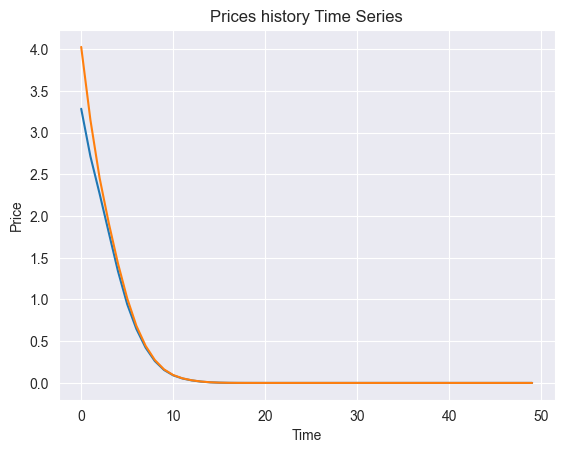

In [ ]:
# Define the market to which the equilibrium policies belong to

# Market parameters
num_buyers = 3
num_goods = 2

utility_type = "linear"




if utility_type == "linear":
    utils = lambda X, T: jnp.sum(T * X, axis = 1).clip(1e-5)
elif utility_type == "cd":
    utils = lambda X, T: jnp.prod(jnp.power(X, T), axis = 1).clip(1e-5)
elif utility_type == "leontief":
    utils = lambda X, T: jnp.min(X / T, axis = 1).clip(1e-5)
else:
    raise ValueError("Invalid utility function!")

utils = jax.jit(utils)


supplies = jnp.array([1.0, 1.0])

types = jnp.array([[2.0, 2.0],
                   [3.0, 3.0],
                   [2.0, 3.0]])*10

budgets = jnp.array([10.0, 10.0, 10.0])
init_state = {"supplies": supplies, "types": types, "budgets": budgets}

ir = 1.0
replenishment = jnp.array([0.0, 0.0, 0.0])

discount = 0.9
num_episodes = 50

market_params = {"init_state": init_state,
                 "ir": ir,
                 "replenishment": replenishment,
                 "discount": discount}

br_network = hk.without_apply_rng(hk.transform(_br_network))
market_actor_network = hk.without_apply_rng(hk.transform(_market_actor_forward))

market = sf.StochasticFisher(utils, market_actor_network, br_network, seed)

# Equilibrium
price_policy = lambda state: prices_actor(state) # have to define them as Lambda funcs so they are hashable
buyer_policy = lambda state: buyer_actor(state, price_policy(state))
traj = market.trajectory(market_params, price_policy, buyer_policy, num_episodes)


eqm_play_hist = (traj.a, traj.b[0], traj.b[1])

plt.plot(traj.a)
plt.title("Prices history Time Series")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


### Run experiment

In [ ]:

util_type = "linear"

# Market parameters
num_goods = 2
num_buyers = 3

num_br_epochs = 200
num_episodes = 50
learn_rate_langmult = 1e-3
learn_rate_players = (1e-2, 1e-5)
# learn_rate_players = 1e-5
learn_rate_br = 1e-5
beta_mult = 1.01
beta = 0.1
num_iters_players = 50
num_iters_langmult = 50
opt_name = "adam"

num_iters = (num_iters_players, num_iters_langmult)
learn_rates = (learn_rate_players, learn_rate_langmult, learn_rate_br)


eqm_play_hist = (traj.a, traj.b[0], traj.b[1])

(l_action, f_action, langmult), (data, figure_hist) = estimate_market_params(eqm_play_hist, learn_rates, num_iters, beta_mult, beta, num_buyers, num_goods, num_episodes, num_br_epochs, util_type, opt_name)

In [ ]:
with imageio.get_writer('figures/toy_example_stoch.gif', mode='I') as writer:
    for fig in figure_hist:
        # Render the plot to a buffer
        canvas = fig.canvas
        canvas.draw()
        buf = canvas.buffer_rgba()
        image = imageio.core.util.Image(np.asarray(buf))
        writer.append_data(image)


# Append the last frame multiple times to create a pause at the end
for i in range(1000):
    writer.append_data(image)